In [1]:
import numpy as np
import emcee
from scipy.optimize import minimize, least_squares, leastsq
from scipy.stats import norm
import matplotlib.pyplot as plt
import corner

In [2]:
data = np.genfromtxt('D1_c_5.dat')
m=data.shape[0]
x=np.zeros(m)
y=np.zeros(m)
sigma=np.zeros(m)
for i in range(data.shape[0]):
    x[i]=data[i][0]
    y[i]=data[i][1]
    sigma[i] = data[i][2]

In [3]:
def log_prior_uni(a):
    if -100 < a.all() < 100:
        return 0.0
    return -np.inf
    
def log_prior_gauss(a, k, abar=5):
    gauss = ((1 / (np.sqrt(2 * np.pi)*abar)) ** (k+1)) * np.exp(- a**2 / (2 * abar**2))
    return np.sum(np.log(gauss))

def g(a, x, k):
    g = 0
    for i in range(k+1):
        g += a[i] * x**i
    return g

def chi_squared(a, x, y, sigma):
    return np.sum(((y - g(a, x, k)) / sigma) ** 2)

def log_likelihood(a, x, y, sigma):
    return np.sum(np.log(1 / ( np.sqrt(2 * np.pi) * sigma))) - chi_squared(a, x, y, sigma) / 2
    
def log_posterior_uni(a, x, y, sigma):
    lp_uni = log_prior_uni(a)
    if not np.isfinite(lp_uni):
        return -np.inf
    return lp_uni + log_likelihood(a, x, y, sigma)

def log_posterior_gauss(a, x, y, sigma):
    lp_gauss = log_prior_gauss(a, k)
    if not np.isfinite(lp_gauss):
        return -np.inf
    return lp_gauss + log_likelihood(a, x, y, sigma)

In [13]:
k = 4     # Order of Taylor_Polynomial, 3 for Corner plots, 4 for correct Fig 3&4

# For Extra task, set k to kmax and exctract terms "a_i" up to order k

fun = lambda *args: -log_likelihood(*args)
initial = np.zeros(k+1) + 0.1 * np.random.randn(k+1)
sol = minimize(fun, initial, args=(x, y, sigma))

In [5]:
starting_guesses = [sol.x] + 1e-4 * np.random.randn(50, k+1)

nwalkers, ndim = starting_guesses.shape

sampler_uni = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_uni, args=(x, y, sigma))

sampler_uni.run_mcmc(starting_guesses, 5000, progress=True);

100%|███████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 345.70it/s]


In [85]:
starting_guesses = np.ones(k+1) + 1e-4 * np.random.randn(50, k+1)

nwalkers, ndim = starting_guesses.shape

sampler_gauss = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gauss, args=(x, y, sigma))

sampler_gauss.run_mcmc(starting_guesses, 5000, progress=True);

100%|███████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 279.91it/s]


In [84]:
flat_samples_uni = sampler_uni.get_chain(discard=1000, thin=15, flat=True)

labels = [r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"]
if k==3:
    fig = corner.corner(flat_samples_uni, labels=labels, titles=labels, show_titles=True);

In [83]:
flat_samples_gauss = sampler_gauss.get_chain(discard=1000, thin=15, flat=True)

labels = [r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"]
if k==3:    
    fig = corner.corner(flat_samples_gauss, labels=labels, titles=labels, show_titles=True);

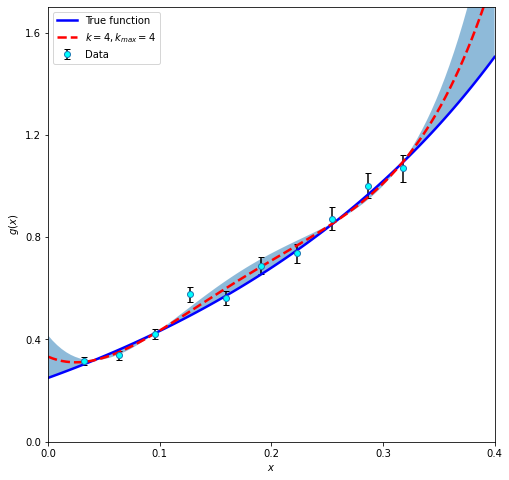

In [131]:
fig = plt.figure(figsize=(8, 8))
plt.errorbar(x, y, (sigma), fmt="o", label="Data", ecolor="black", capsize=3.0, mfc='aqua')
plt.xlim(0.0, 0.4)
plt.xticks(np.linspace(0.0, 0.4, 5))
plt.xlabel(r"$x$")
plt.ylim(0.0, 1.7)
plt.yticks(np.linspace(0.0, 1.6, 5))
plt.ylabel(r"$g(x)$")
x_range = np.linspace(0.0, 0.4, 100)
func = ((1 / 2) + np.tan(np.pi/2 * x_range))**2
plt.plot(x_range, func, label=r"True function", color="b", lw=2.5)
a = sol.x
apprx = g(a, x_range, k)
plt.fill_between(x_range, apprx - abs(func-apprx), apprx + abs(apprx-func), alpha=0.5)
plt.plot(x_range, apprx, 'r--', label=f"$k={k}, k_"r"{max}="f"{k}$", lw=2.5)
plt.legend(loc='upper left');

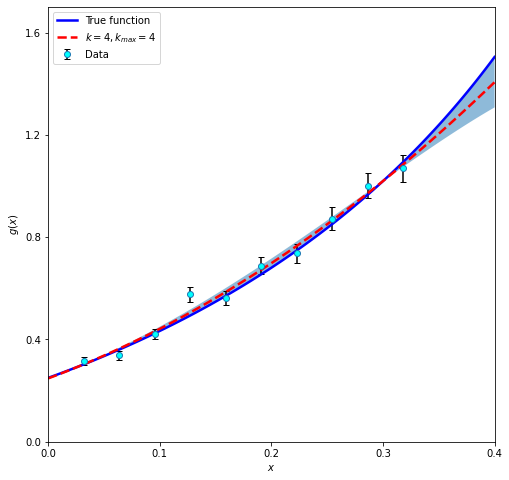

In [121]:
fig = plt.figure(figsize=(8, 8))
plt.errorbar(x, y, (sigma), fmt="o", label="Data", ecolor="black", capsize=3.0, mfc='aqua')
plt.xlim(0.0, 0.4)
plt.xticks(np.linspace(0.0, 0.4, 5))
plt.xlabel(r"$x$")
plt.ylim(0.0, 1.7)
plt.yticks(np.linspace(0.0, 1.6, 5))
plt.ylabel(r"$g(x)$")
x_range = np.linspace(0.0, 0.4, 100)
func = ((1 / 2) + np.tan(np.pi/2 * x_range))**2
plt.plot(x_range, func, label=r"True function", color="b", lw=2.5)
a = np.zeros([k+1, 1])
for i in range(flat_samples_gauss.shape[1]):
    a[i] = flat_samples_gauss[:,i].mean()
apprx = g(a, x_range, k)
plt.fill_between(x_range, apprx -abs(func-apprx), apprx+ abs(apprx-func), alpha=0.5)
plt.plot(x_range, apprx, 'r--', label=f"$k={k}, k_"r"{max}="f"{k}$", lw=2.5)
plt.legend(loc='upper left');
plt.show()

In [11]:
for k in range(0,7):
    starting_guesses = np.ones(k+1) + 1e-4 * np.random.randn(50, k+1)
    nwalkers, ndim = starting_guesses.shape
    sampler_uni = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_uni, args=(x, y, sigma))
    sampler_uni.run_mcmc(starting_guesses, 1000)
    flat_samples_uni = sampler_uni.get_chain(discard=100, thin=15, flat=True)
    print(f"kmax = {k}")
    for i in range(k+1):
        a = np.round(flat_samples_uni[:,i].mean(), 2)
        var = np.round(((np.percentile(flat_samples_uni[:,i], [84])[0]  - a) + (a - np.percentile(flat_samples_uni[:,i], [16]))[0]) / 2, 2)
        if i <=2:
            print(f"a{i}:",a, "+-", var)
    print('------------------------------------------------')

kmax = 0
a0: 0.48 +- 0.01
------------------------------------------------
kmax = 1
a0: 0.2 +- 0.01
a1: 2.55 +- 0.11
------------------------------------------------
kmax = 2
a0: 0.25 +- 0.02
a1: 1.56 +- 0.4
a2: 3.35 +- 1.28
------------------------------------------------
kmax = 3
a0: 0.27 +- 0.04
a1: 1.0 +- 1.03
a2: 7.74 +- 7.73
------------------------------------------------
kmax = 4
a0: 0.32 +- 0.07
a1: -1.33 +- 2.82
a2: 38.04 +- 34.43
------------------------------------------------
kmax = 5
a0: 0.51 +- 0.17
a1: -11.64 +- 9.29
a2: 221.51 +- 163.77
------------------------------------------------
kmax = 6
a0: 0.54 +- 0.28
a1: -13.61 +- 16.1
a2: 263.3 +- 308.83
------------------------------------------------


In [12]:
for k in range(0,7):
    starting_guesses = np.ones(k+1) + 1e-4 * np.random.randn(50, k+1)
    nwalkers, ndim = starting_guesses.shape
    sampler_gauss = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gauss, args=(x, y, sigma))
    sampler_gauss.run_mcmc(starting_guesses, 1000)
    flat_samples_gauss = sampler_gauss.get_chain(discard=100, thin=15, flat=True)
    print(f"kmax = {k}")
    for i in range(k+1):
        a = np.round(flat_samples_gauss[:,i].mean(), 2)
        var = np.round(np.percentile(flat_samples_gauss[:,i], [84])  - a, 2)[0]
        if i <=2:
            print(f"a{i}:",a, "+-", var)
    print('------------------------------------------------')

kmax = 0
a0: 0.48 +- 0.0
------------------------------------------------
kmax = 1
a0: 0.2 +- 0.02
a1: 2.55 +- 0.1
------------------------------------------------
kmax = 2
a0: 0.25 +- 0.02
a1: 1.63 +- 0.38
a2: 3.14 +- 1.22
------------------------------------------------
kmax = 3
a0: 0.25 +- 0.02
a1: 1.64 +- 0.45
a2: 2.92 +- 2.29
------------------------------------------------
kmax = 4
a0: 0.25 +- 0.02
a1: 1.64 +- 0.45
a2: 2.97 +- 2.38
------------------------------------------------
kmax = 5
a0: 0.25 +- 0.02
a1: 1.66 +- 0.46
a2: 2.85 +- 2.36
------------------------------------------------
kmax = 6
a0: 0.25 +- 0.02
a1: 1.62 +- 0.45
a2: 3.19 +- 2.3
------------------------------------------------
